# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [3]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq

## SCIP computed features

In [4]:
df = pq.read_table("/data/weizmann/EhV/weizmann-ehv-metadata/representations/scip/011020211530/features.parquet").to_pandas()

In [12]:
df["meta_sample"] = df["meta_1"].map(lambda p: Path(p).parts[-2])

In [14]:
df["meta_sample"].value_counts()

H1_T9    14675
H1_T7    10286
H1_T8    10164
H2_T7     8113
H2_T9     6474
H2_T8     4756
Name: meta_sample, dtype: int64

In [5]:
df.shape

(54468, 484)

In [14]:
df["meta_1"]

idx
0        /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
1        /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
2        /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
3        /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
4        /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
                               ...                        
54463    /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
54464    /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
54465    /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
54466    /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
54467    /vsc-mounts/gent-user/420/vsc42015/vsc_data_vo...
Name: meta_1, Length: 54468, dtype: object

In [74]:
df["meta_path"] = df["meta_path"].map(lambda p: "/data/VIB/Vulcan/Jim_MosProtoplasts/"+p)

In [75]:
df.shape

(10000, 385)

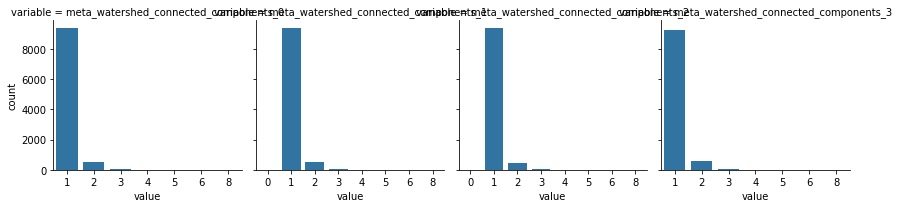

In [12]:
grid = seaborn.FacetGrid(
    data=df.melt(value_vars=df.filter(regex='connected_components')),
    col="variable",
    sharex=False
)
grid.map_dataframe(seaborn.countplot, x="value")

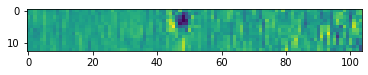

In [13]:
plt.imshow(tifffile.imread(df[df["meta_watershed_connected_components_0"] == 2].iloc[4]["meta_path"], key=0))

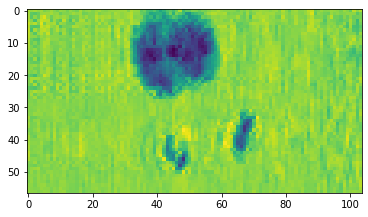

In [14]:
plt.imshow(tifffile.imread(df[df["meta_watershed_connected_components_0"] == 3].iloc[0]["meta_path"], key=0))

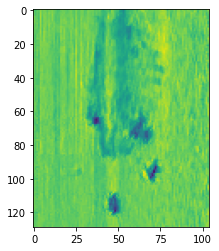

In [15]:
plt.imshow(tifffile.imread(df[df["meta_watershed_connected_components_0"] == 4].iloc[0]["meta_path"], key=0))

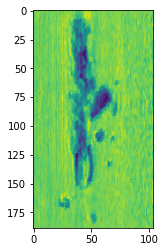

In [16]:
plt.imshow(tifffile.imread(df[df["meta_watershed_connected_components_0"] == 5].iloc[0]["meta_path"], key=0))

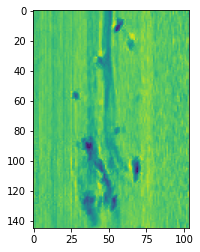

In [17]:
plt.imshow(tifffile.imread(df[df["meta_watershed_connected_components_0"] == 6].iloc[0]["meta_path"], key=0))

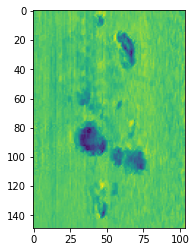

In [18]:
plt.imshow(tifffile.imread(df[df["meta_watershed_connected_components_0"] == 8].iloc[0]["meta_path"], key=0))

In [19]:
(df.filter(regex="connected") > 1).any(axis=1).sum()

1184

In [20]:
df = df[~(df.filter(regex="connected") > 1).any(axis=1)]

In [21]:
df.shape

(8816, 385)

## NaN filter

In [22]:
df=df[~df.filter(regex="bbox").isna().any(axis=1)]

## Zero-variance filter

In [23]:
df.head()

,feat_watershed_area_0,feat_watershed_convex_area_0,feat_watershed_eccentricity_0,feat_watershed_equivalent_diameter_0,feat_watershed_euler_number_0,feat_watershed_feret_diameter_max_0,feat_watershed_filled_area_0,feat_watershed_inertia_tensor-0-0_0,feat_watershed_inertia_tensor-0-1_0,feat_watershed_inertia_tensor-1-0_0,...,feat_watershed_hog_ch_3_35,meta_watershed_bbox_minr,meta_watershed_bbox_minc,meta_watershed_bbox_maxr,meta_watershed_bbox_maxc,meta_watershed_connected_components_0,meta_watershed_connected_components_1,meta_watershed_connected_components_2,meta_watershed_connected_components_3,meta_path
idx,,,,,,,,,,,,,,,,,,,,,
0,85.0,88.0,0.422656,10.403142,1.0,12.083046,85.0,7.377716,-0.458547,-0.458547,...,0.000000,4.0,41.0,15.0,56.0,1,1,1,1,/data/VIB/Vulcan/Jim_MosProtoplasts/20200831_1...
1,78.0,83.0,0.769619,9.965575,1.0,13.152946,78.0,4.036818,0.484221,0.484221,...,0.624049,1.0,45.0,14.0,53.0,1,1,1,1,/data/VIB/Vulcan/Jim_MosProtoplasts/20200831_1...
2,47.0,50.0,0.624419,7.735778,1.0,9.486833,47.0,3.175192,0.641919,0.641919,...,0.000000,3.0,43.0,12.0,52.0,1,1,1,1,/data/VIB/Vulcan/Jim_MosProtoplasts/20200831_1...
3,481.0,502.0,0.619672,24.747287,1.0,28.635642,481.0,31.111484,3.471730,3.471730,...,0.500000,0.0,39.0,27.0,64.0,1,1,1,1,/data/VIB/Vulcan/Jim_MosProtoplasts/20200831_1...
4,245.0,260.0,0.811008,17.661928,1.0,23.769729,245.0,13.356368,6.056543,6.056543,...,0.201780,0.0,42.0,22.0,59.0,1,1,1,1,/data/VIB/Vulcan/Jim_MosProtoplasts/20200831_1...


In [24]:
df = df.drop(columns=df.filter(regex="feat.*").loc[:, df.filter(regex="feat.*").std(axis=0) == 0].columns) # remove feature columns which have no variance

In [25]:
df.shape

(8806, 385)

In [26]:
# export
def df_filter(df):
    df = df.filter(regex="(_[0123]|meta)") # only channels 0 to 3 are of interest
    df = df.loc[:, ~df.isna().all(axis=0)]
    df = df.drop(columns=df.filter(regex="feat.*").loc[:, df.filter(regex="feat.*").std(axis=0) == 0].columns) # remove feature columns which have no variance
    
    return df

# Spotting multiplets that are missed during segmentation

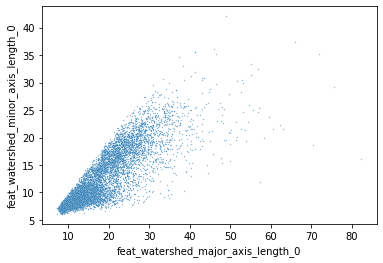

In [27]:
ax = seaborn.scatterplot(data=df, x="feat_watershed_major_axis_length_0", y="feat_watershed_minor_axis_length_0", s=2, alpha=0.5)

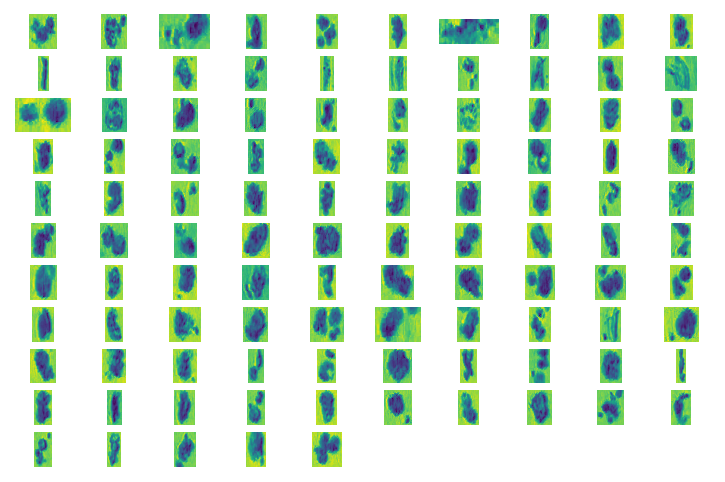

In [28]:
sel1 = df["feat_watershed_major_axis_length_0"] > 40
sel2 = df["feat_watershed_minor_axis_length_0"] < 40

core.plot_gate(sel1 & sel2, df)

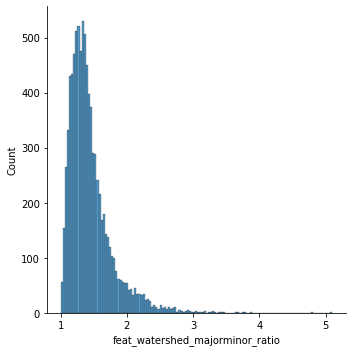

In [29]:
df["feat_watershed_majorminor_ratio"] = df["feat_watershed_major_axis_length_0"] / df["feat_watershed_minor_axis_length_0"]
ax = seaborn.displot(data=df, x="feat_watershed_majorminor_ratio")

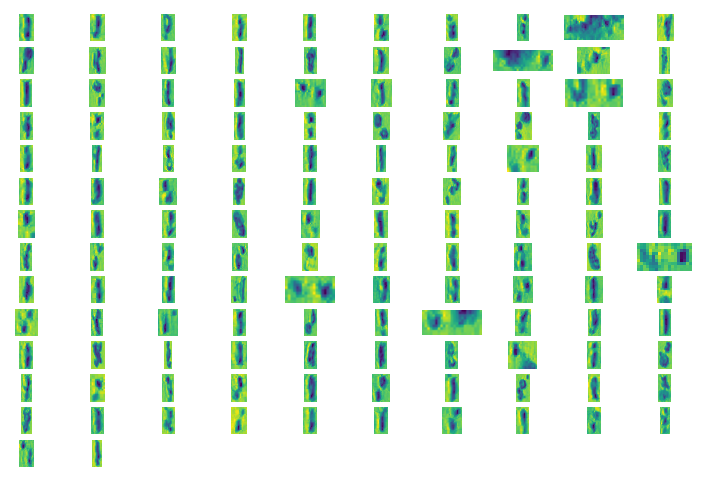

In [30]:
sel1 = df["feat_watershed_majorminor_ratio"] > 2.5

core.plot_gate(sel1, df)

In [31]:
df = df[~sel1]
df.shape

(8674, 386)

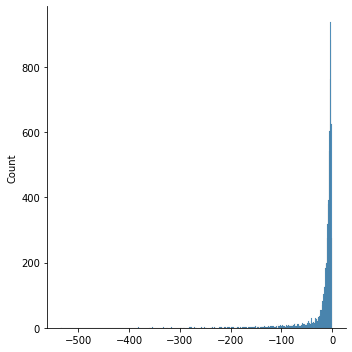

In [32]:
seaborn.displot(data=df["feat_watershed_area_0"] - df["feat_watershed_convex_area_0"])

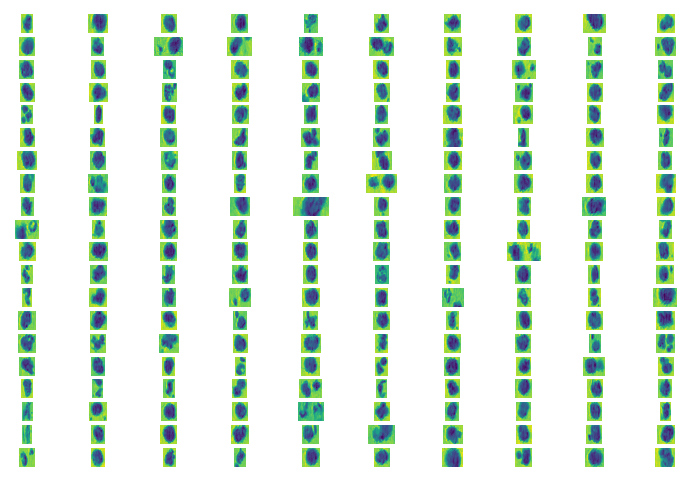

In [33]:
sel1 = (df["feat_watershed_area_0"] - df["feat_watershed_convex_area_0"]) < -100

core.plot_gate(sel1, df)

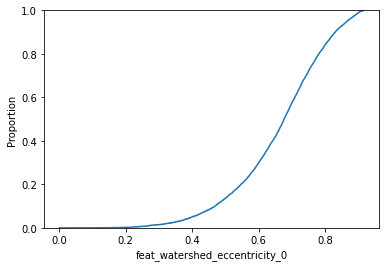

In [34]:
ax = seaborn.ecdfplot(data=df, x="feat_watershed_eccentricity_0")

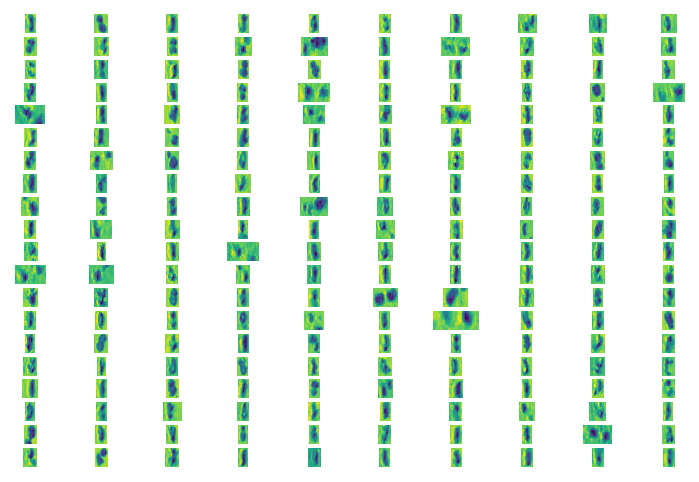

In [35]:
sel1 = df["feat_watershed_eccentricity_0"] > 0.85

core.plot_gate(sel1, df)

In [36]:
df = df[~sel1]
df.shape

(8055, 386)

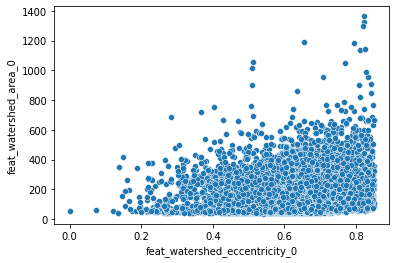

In [37]:
ax = seaborn.scatterplot(data=df, x="feat_watershed_eccentricity_0", y="feat_watershed_area_0")

In [38]:
df.shape

(8055, 386)

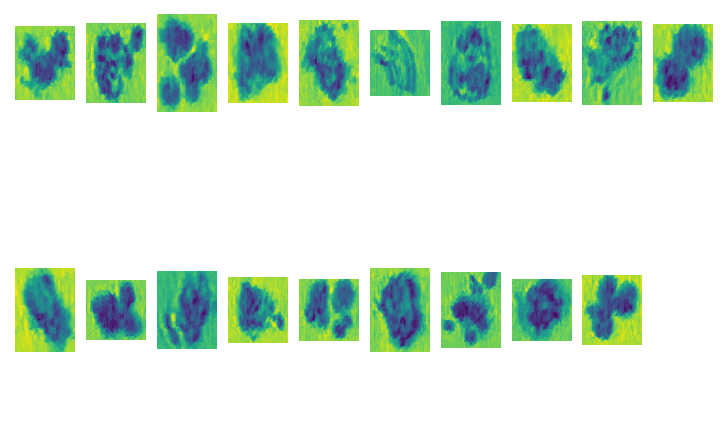

In [39]:
core.plot_gate(df["feat_watershed_area_0"] > 800, df)

In [40]:
df = df[df["feat_watershed_area_0"] < 800]

In [41]:
df.shape

(8036, 386)

# Noisy events

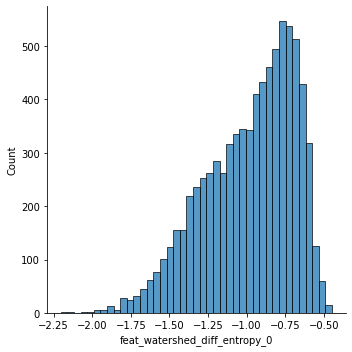

In [42]:
grid = seaborn.displot(data=df, x="feat_watershed_diff_entropy_0")

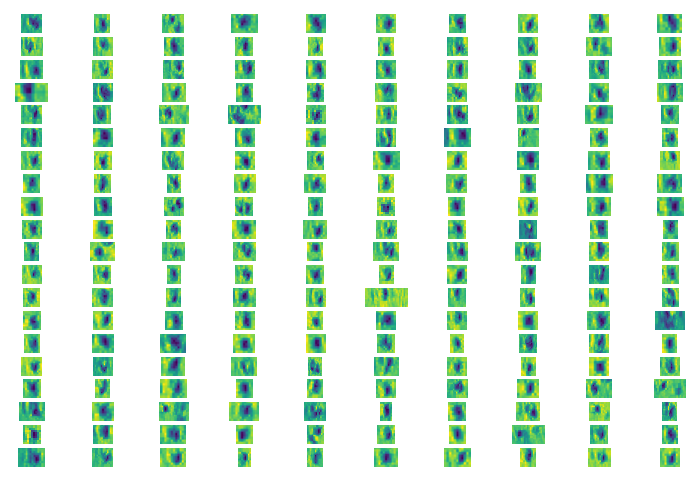

In [43]:
core.plot_gate(df["feat_watershed_diff_entropy_0"] < -1.6, df)

In [44]:
df = df[df["feat_watershed_diff_entropy_0"] > -1.6]
df.shape

(7801, 386)

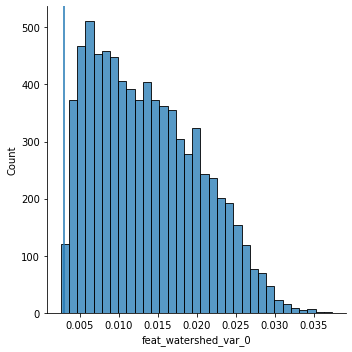

In [45]:
grid = seaborn.displot(data=df, x="feat_watershed_var_0")
grid.ax.axvline(0.003)

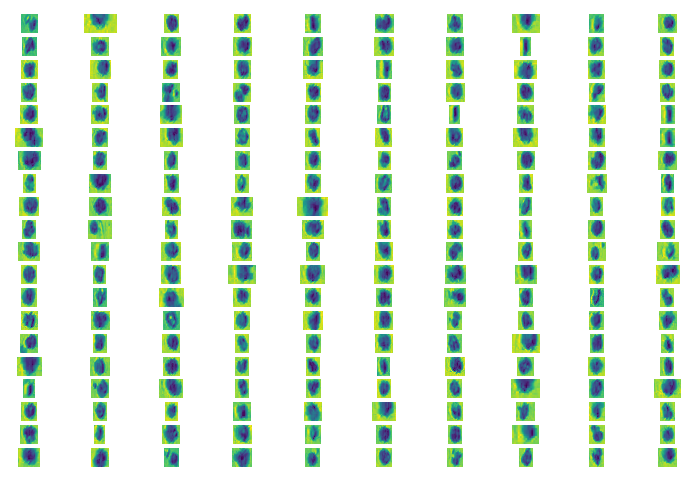

In [46]:
core.plot_gate(df["feat_watershed_var_0"] > 0.02, df)

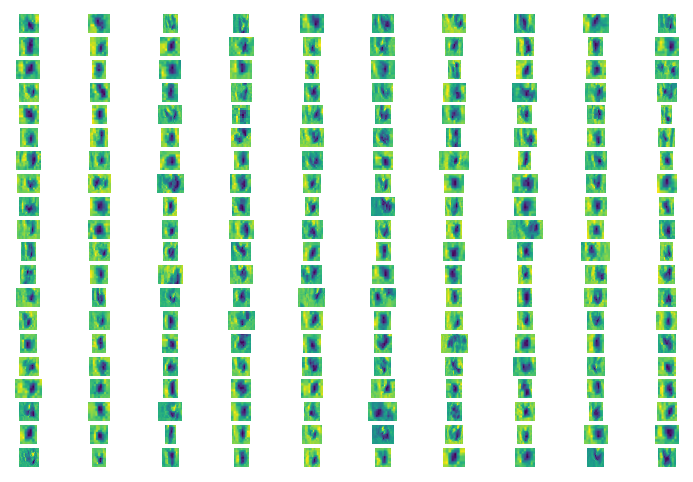

In [47]:
core.plot_gate(df["feat_watershed_var_0"] < 0.005, df, sort="feat_watershed_var_0")

# Feature correlation

In [48]:
df = df.drop(columns=df.filter(regex="feat.*").loc[:, df.filter(regex="feat.*").std(axis=0) == 0].columns) # remove feature columns which have no variance

In [49]:
correlation = df.filter(regex="feat_.*").corr()

In [50]:
correlation

,feat_watershed_area_0,feat_watershed_convex_area_0,feat_watershed_eccentricity_0,feat_watershed_equivalent_diameter_0,feat_watershed_euler_number_0,feat_watershed_feret_diameter_max_0,feat_watershed_filled_area_0,feat_watershed_inertia_tensor-0-0_0,feat_watershed_inertia_tensor-0-1_0,feat_watershed_inertia_tensor-1-0_0,...,feat_watershed_hog_ch_3_27,feat_watershed_hog_ch_3_28,feat_watershed_hog_ch_3_29,feat_watershed_hog_ch_3_30,feat_watershed_hog_ch_3_31,feat_watershed_hog_ch_3_32,feat_watershed_hog_ch_3_33,feat_watershed_hog_ch_3_34,feat_watershed_hog_ch_3_35,feat_watershed_majorminor_ratio
feat_watershed_area_0,1.000000,0.987618,0.097088,0.986685,-0.373161,0.968191,0.988345,0.910029,0.031688,0.031688,...,0.014728,0.102365,0.217779,-0.070400,-0.130455,-0.135691,-0.058015,0.006633,0.047293,0.110354
feat_watershed_convex_area_0,0.987618,1.000000,0.097324,0.973157,-0.476659,0.972407,0.997510,0.938023,0.038897,0.038897,...,0.023068,0.111049,0.220651,-0.070090,-0.123400,-0.129757,-0.051857,0.009428,0.056261,0.109427
feat_watershed_eccentricity_0,0.097088,0.097324,1.000000,0.113542,-0.005851,0.236223,0.092663,-0.031520,0.028539,0.028539,...,0.026695,0.077800,0.041380,-0.017684,0.034758,0.042899,-0.014153,-0.020782,0.029690,0.931304
feat_watershed_equivalent_diameter_0,0.986685,0.973157,0.113542,1.000000,-0.374107,0.980817,0.974609,0.901892,0.029099,0.029099,...,0.012333,0.083997,0.239868,-0.058319,-0.154320,-0.152481,-0.061943,0.018506,0.032456,0.128696
feat_watershed_euler_number_0,-0.373161,-0.476659,-0.005851,-0.374107,1.000000,-0.435971,-0.488319,-0.505152,-0.026596,-0.026596,...,-0.045414,-0.065512,-0.116237,0.016963,0.022071,0.025197,-0.024211,-0.032478,-0.053033,0.012253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feat_watershed_hog_ch_3_32,-0.135691,-0.129757,0.042899,-0.152481,0.025197,-0.141939,-0.127967,-0.159270,-0.032416,-0.032416,...,0.202015,0.155455,0.093416,0.006609,0.441639,1.000000,0.158733,-0.188529,0.041325,0.047002
feat_watershed_hog_ch_3_33,-0.058015,-0.051857,-0.014153,-0.061943,-0.024211,-0.061839,-0.048647,-0.073669,-0.056364,-0.056364,...,0.085458,-0.006258,0.090725,0.189327,0.342870,0.158733,1.000000,0.107616,-0.008429,-0.024440
feat_watershed_hog_ch_3_34,0.006633,0.009428,-0.020782,0.018506,-0.032478,0.013936,0.012334,0.008466,-0.075020,-0.075020,...,-0.033855,-0.138065,0.082514,0.251111,-0.045353,-0.188529,0.107616,1.000000,0.019523,-0.045704
feat_watershed_hog_ch_3_35,0.047293,0.056261,0.029690,0.032456,-0.053033,0.043026,0.055275,0.039114,-0.097406,-0.097406,...,0.122579,0.208065,-0.062540,-0.128704,0.199184,0.041325,-0.008429,0.019523,1.000000,0.048175


## Overall feature correlation

/opt/conda/envs/env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


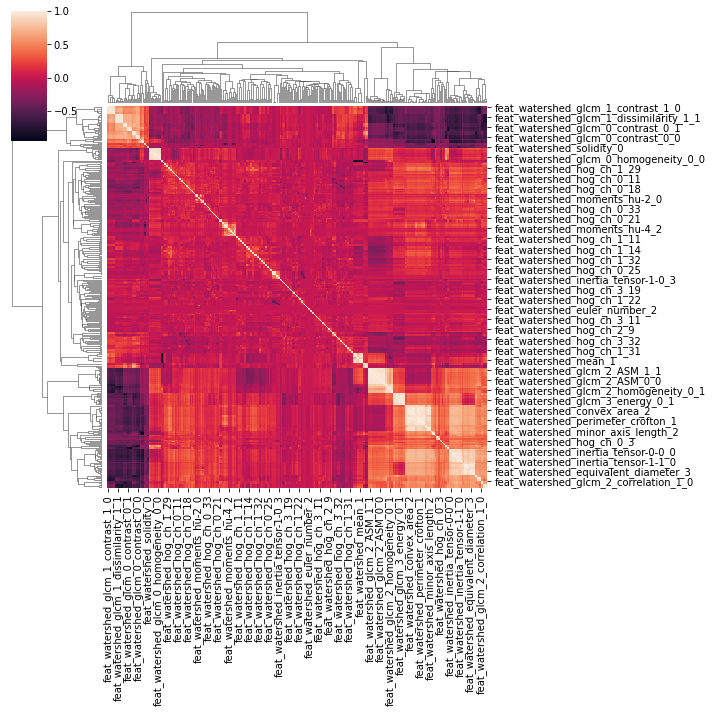

In [51]:
seaborn.clustermap(correlation)

In [65]:
# export
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > 0.9:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [66]:
correlated_features = get_correlated_features(df.filter(regex="feat"))
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

/opt/conda/envs/env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


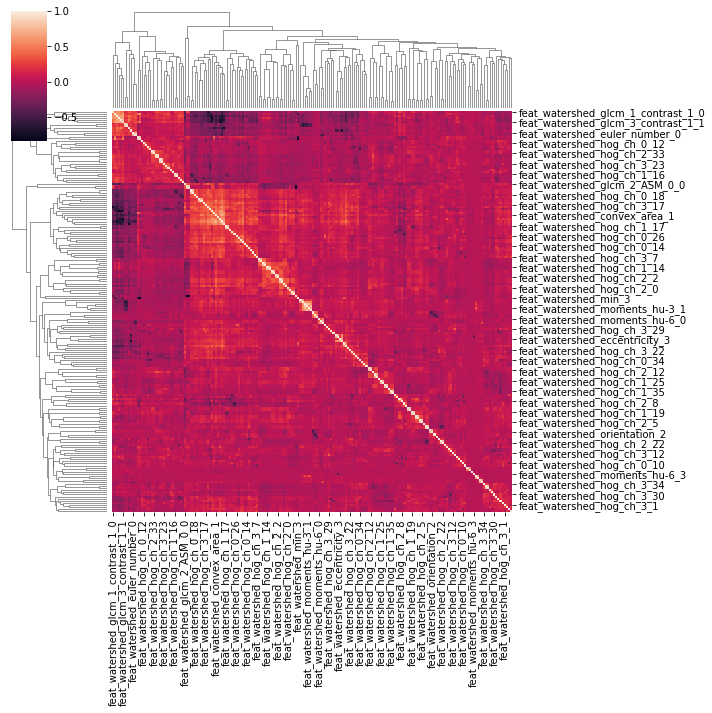

In [67]:
seaborn.clustermap(correlation2)

In [68]:
df = df.drop(columns=correlated_features)

In [69]:
df.shape

(7801, 203)

In [70]:
len(df.index.values)

7801

In [71]:
numpy.save("/data/VIB/Vulcan/vib-vulcan-metadata/preprocessing/correlated_features.npy", list(correlated_features))

In [72]:
numpy.save("/data/VIB/Vulcan/vib-vulcan-metadata/preprocessing/single_focused_index.npy", df.index.values)